In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import math
import warnings
from sklearn.metrics import mean_squared_error
from matplotlib.dates import YearLocator, DateFormatter
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA

import ipywidgets as widgets
from ipywidgets import interact

import sys
sys.path.insert(0, os.path.abspath('../Libraries'))
import countries as cLib

ModuleNotFoundError: No module named 'sklearn'

In [2]:
df = pd.read_csv('../Datasets/cleaned_Productivity.csv')
df.drop('mean', axis=1, inplace=True)
df_formatted = pd.melt(df, id_vars = ['LOCATION'], var_name = 'YEAR', value_name= 'PRODUCTIVITY')
df_formatted = df_formatted.sort_values(['LOCATION', 'YEAR'], ascending=[True, True])
df_formatted = df_formatted.reset_index(drop=True)
df_formatted['YEAR'] = pd.to_numeric(df_formatted['YEAR'])

# Per country

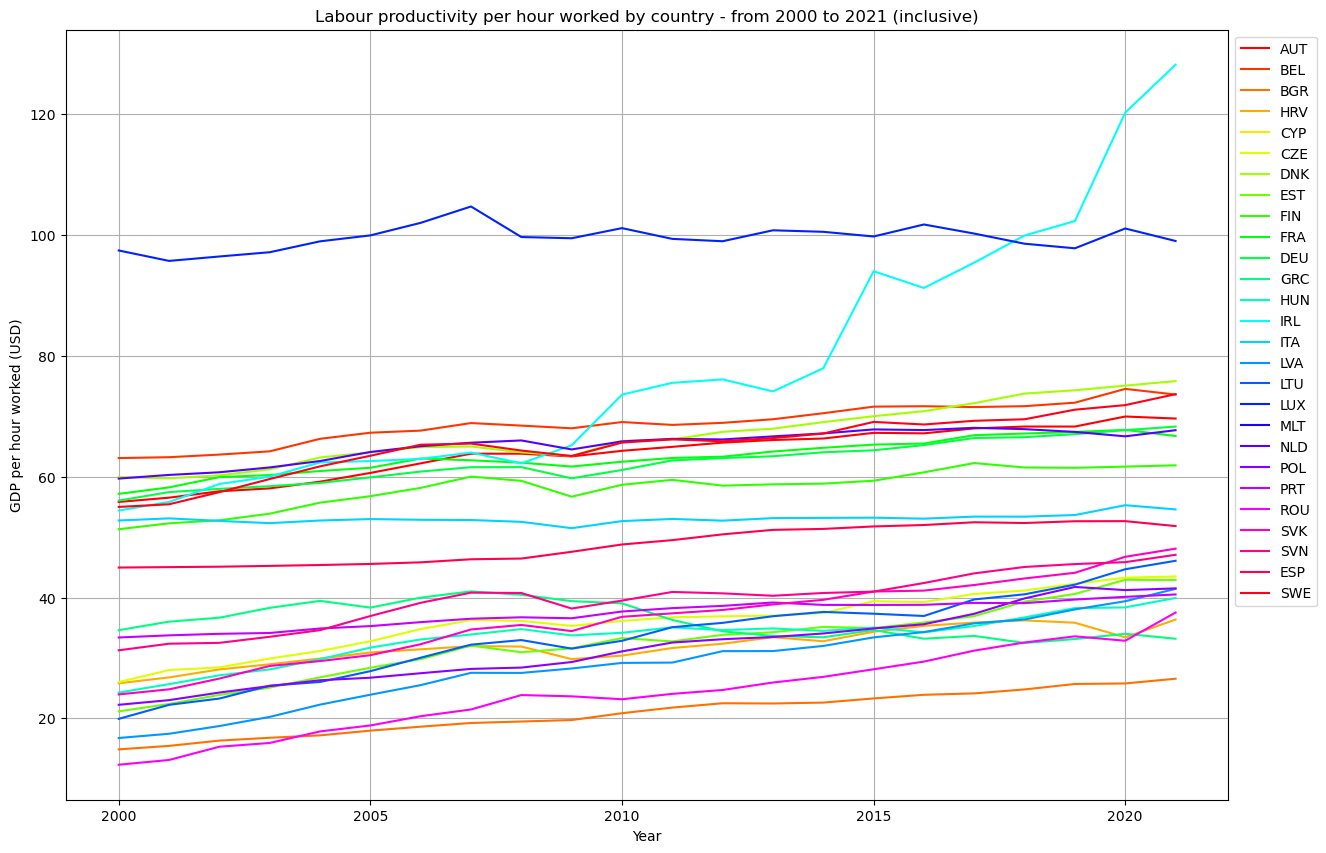

In [3]:
# Plot the data
plt.subplots(figsize=(15, 10))
countries = cLib.get_countries()
colors = plt.cm.hsv(np.linspace(0, 1, len(countries)))

for i, country in enumerate(countries):
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    plt.plot(country_data['YEAR'], country_data['PRODUCTIVITY'], color=colors[i], label=country_code)
    
plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel("Year")
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by country - from 2000 to 2021 (inclusive)")
plt.show()

## Exponential smoothing

In [4]:
# REFERENCE: https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html
def plot_smoothed_data(name, series, index):
    # Smooth series and predict 5 years ahead
    pred_date_start = 2021
    pred_date_end = 2021 + 5
    index_pred = pd.date_range(start=str(pred_date_start), end=str(pred_date_end), freq='AS')

    # Simple Exponential Smoothing (SES)
    fit = SimpleExpSmoothing(series, initialization_method="estimated").fit()
    forecast = fit.forecast(5)
    ses_smoothed = fit.fittedvalues
    ses_forecast = forecast.values
    ses_forecast = np.insert(ses_forecast, 0, ses_smoothed[-1])

    # Exponential Smoothing
    fit = ExponentialSmoothing(
        series,
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(5)
    exp_smoothed = fit.fittedvalues
    exp_forecast = forecast.values
    exp_forecast = np.insert(exp_forecast, 0, exp_smoothed[-1])

    plt.plot(index, series, color='black', label='Actual')
    plt.plot(index, ses_smoothed, color='red', label='SES smoothing', linestyle='--')
    plt.plot(index_pred, ses_forecast, color='red', label='SES Forecast', linestyle='dotted')
    plt.plot(index, exp_smoothed, color='blue', label='Exponential smoothing', linestyle='--')
    plt.plot(index_pred, exp_forecast, color='blue', label='Exponential Forecast', linestyle='dotted')
    
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
    plt.xlabel("Year")
    plt.ylabel('GDP per hour worked (USD)')
    plt.title(f"Labour productivity per hour worked by {name} - from 2000 to 2021 (inclusive)")
    plt.show()

In [5]:
# Get the mean data for each year
path = "../Datasets/cleaned_Productivity.csv"
df_labour = pd.read_csv(path)
df_labour.rename(columns=lambda x: int(x) if x.isdigit() else x, inplace=True)
df_labour.drop(columns=['mean'], inplace=True)
df_labour = df_labour[df_labour['LOCATION'].isin(cLib.get_alpha_3_list())]
df_labour.reset_index(drop=True, inplace=True)
df_labour_mean = df_labour.mean(numeric_only=True, axis=0)
df_labour_mean = pd.DataFrame(df_labour_mean, columns=['PRODUCTIVITY'])
df_labour_mean.index.freq = 'AS'

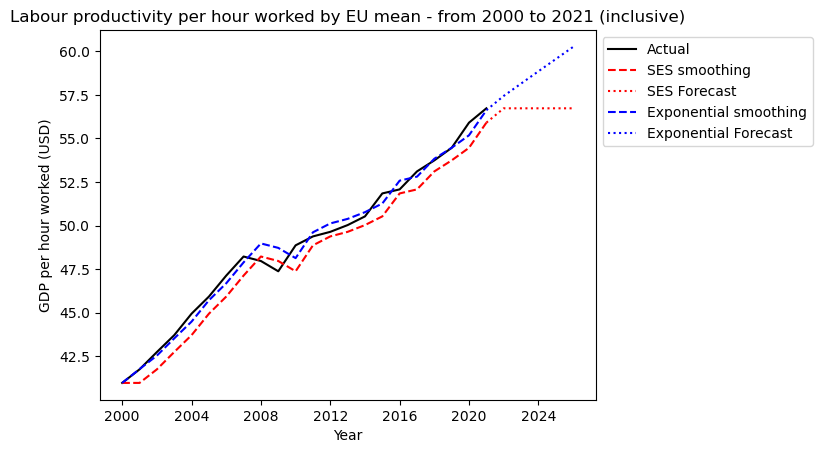

In [6]:
# Exponential smoothing
index = pd.date_range(start='2000', end='2021', freq='AS')
labour_mean_series = pd.Series(df_labour_mean['PRODUCTIVITY'].values, index=index)
plot_smoothed_data("EU mean", labour_mean_series, index)

Due to the horizontal line from the SES prediction (SES assumes that the time series has an underlying constant level), it is clearly a poor choice for predicting, so the general exponential smoothing will be used instead

Let's see if we limit the time series up to 2016, can it predict accurately up to 2021?

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


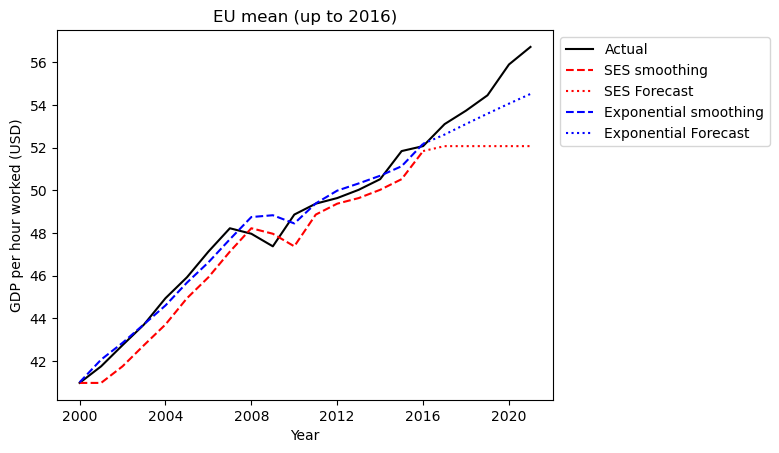

In [7]:
def plot_smoothed_data_past(title, series, index, pred_date_start=2022):
    # Smooth series and predict 5 years ahead
    pred_date_end = pred_date_start + 5
    actual_time = pred_date_start - 2000 + 1
    prediction_time = pred_date_end - pred_date_start
    index_actual = pd.date_range(start='2000', end=str(pred_date_start), freq='AS')
    index_pred = pd.date_range(start=str(pred_date_start), end=str(pred_date_end), freq='AS')

    # Simple Exponential Smoothing (SES)
    fit = SimpleExpSmoothing(series[:actual_time], initialization_method="estimated").fit()
    forecast = fit.forecast(prediction_time)
    ses_smoothed = fit.fittedvalues
    ses_forecast = forecast.values
    ses_forecast = np.insert(ses_forecast, 0, ses_smoothed[-1])

    # Exponential Smoothing
    fit = ExponentialSmoothing(
        series[:actual_time],
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(5)
    exp_smoothed = fit.fittedvalues
    exp_forecast = forecast.values
    exp_forecast = np.insert(exp_forecast, 0, exp_smoothed[-1])

    plt.plot(index, series, color='black', label='Actual')
    plt.plot(index_actual, ses_smoothed, color='red', label='SES smoothing', linestyle='--')
    plt.plot(index_pred, ses_forecast, color='red', label='SES Forecast', linestyle='dotted')
    plt.plot(index_actual, exp_smoothed, color='blue', label='Exponential smoothing', linestyle='--')
    plt.plot(index_pred, exp_forecast, color='blue', label='Exponential Forecast', linestyle='dotted')
    
    plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
    plt.xlabel("Year")
    plt.ylabel('GDP per hour worked (USD)')
    plt.title(title)
    plt.show()
plot_smoothed_data_past("EU mean (up to 2016)", labour_mean_series, index, pred_date_start=2016)

Let's test on all of the countries separately

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


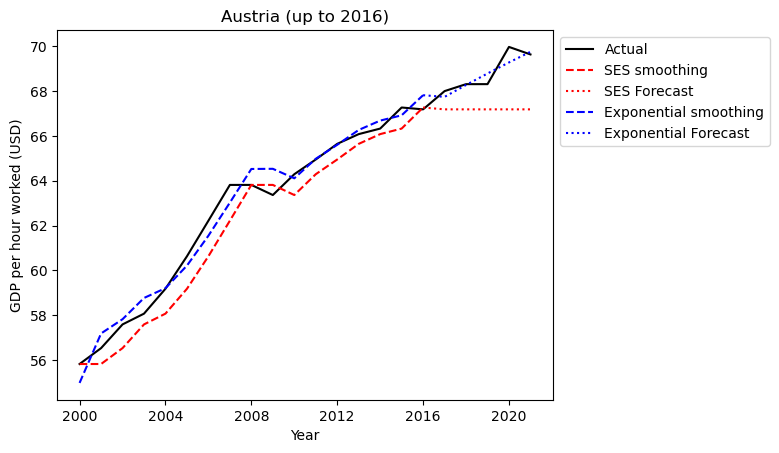

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


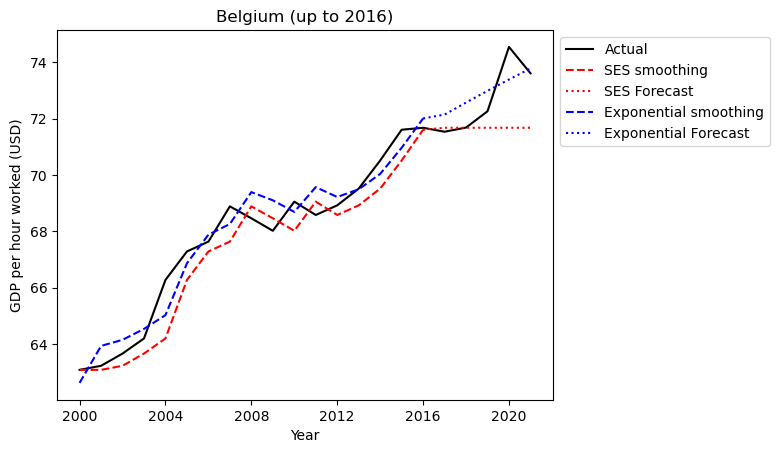

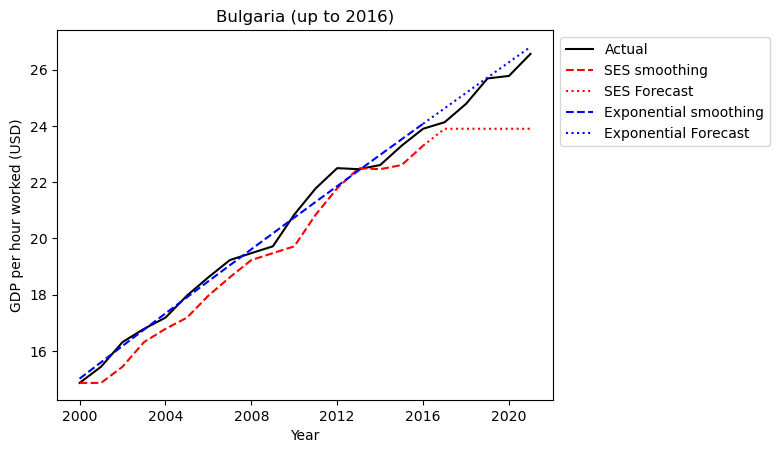

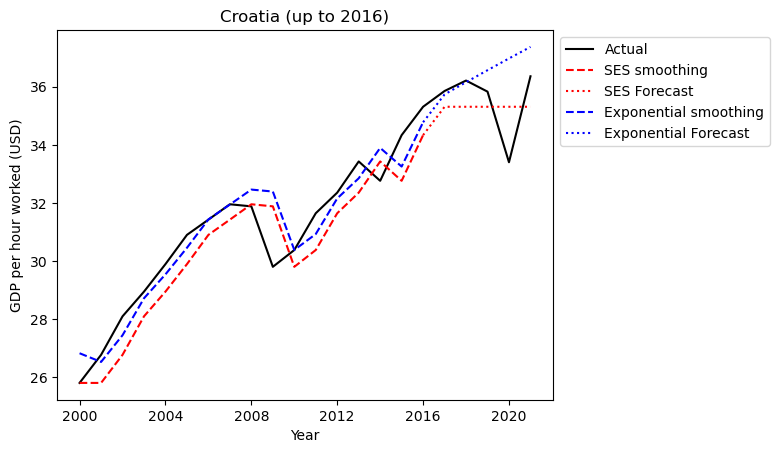

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


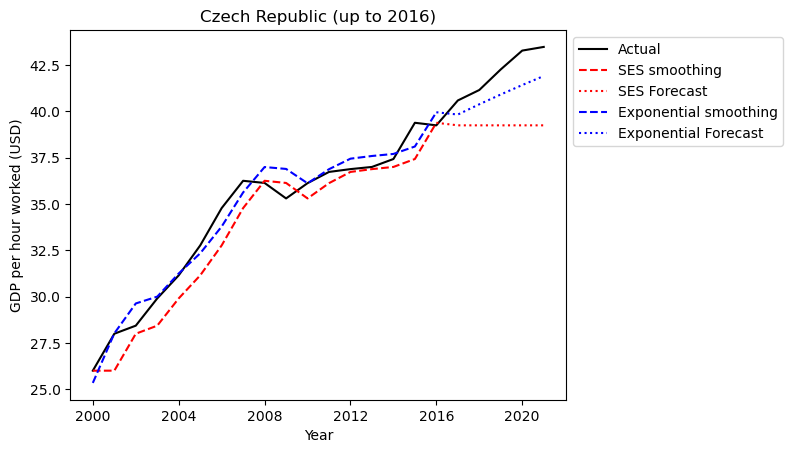

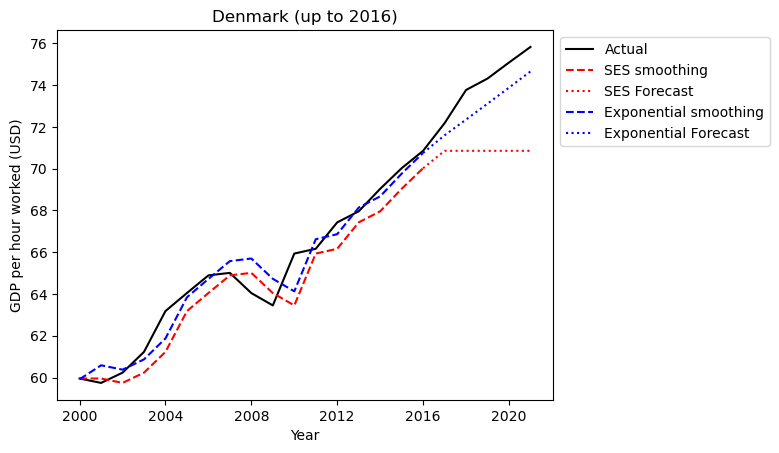

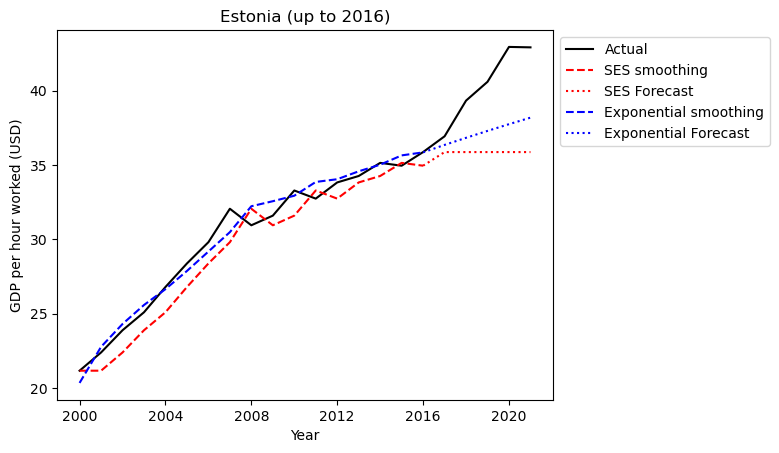

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


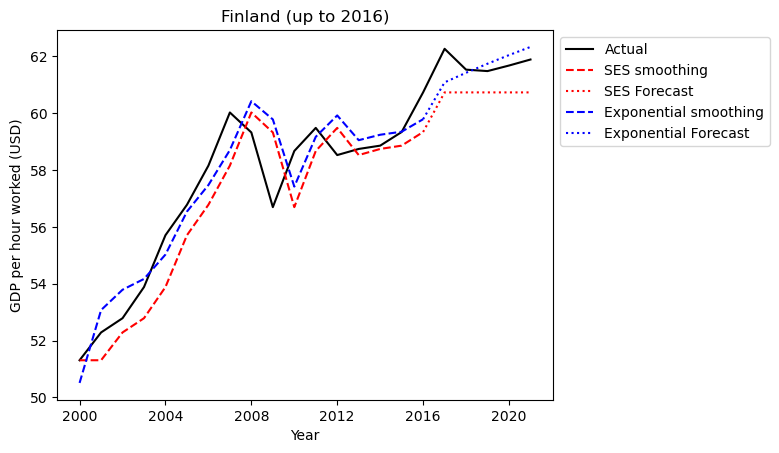

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


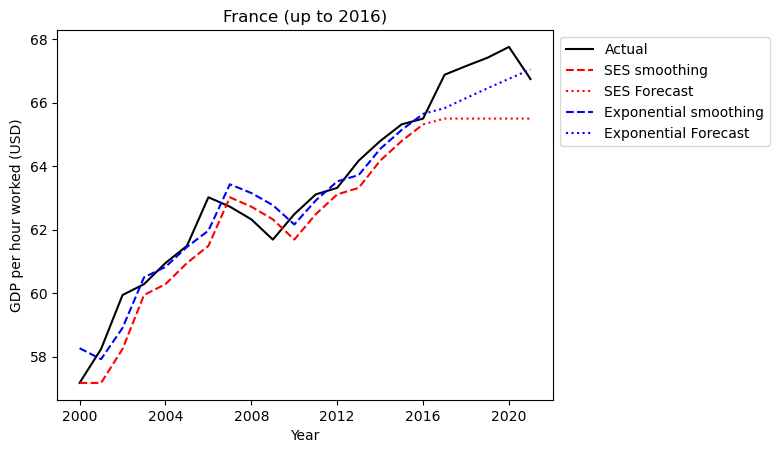

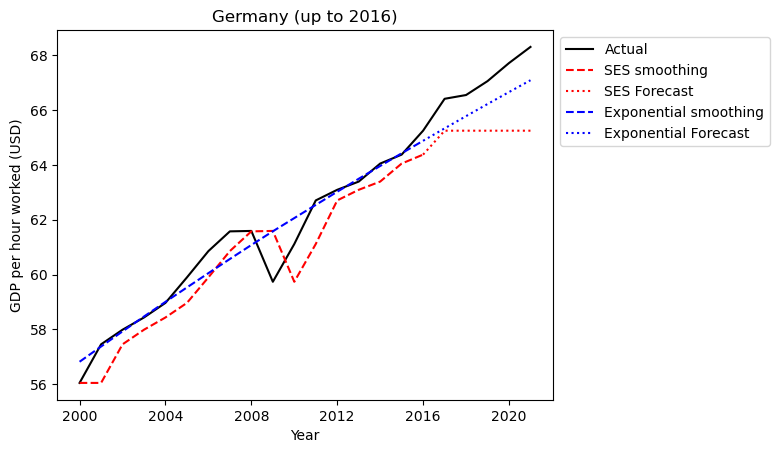

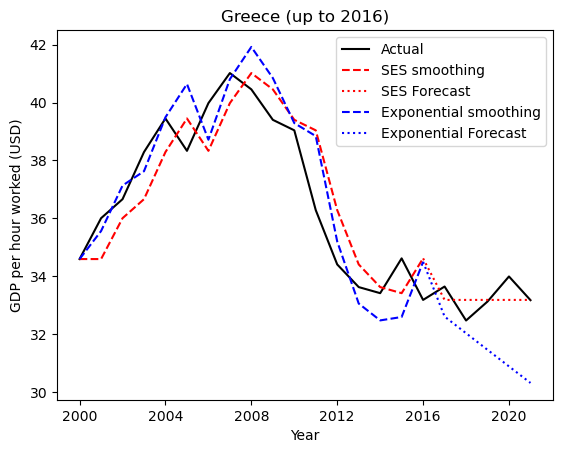

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


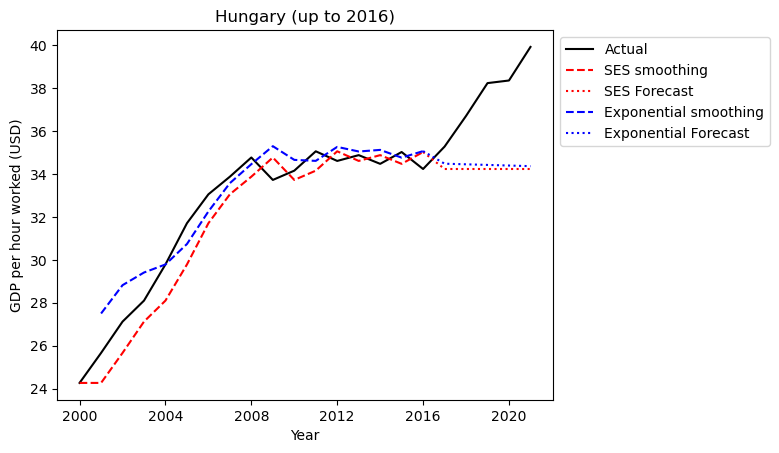

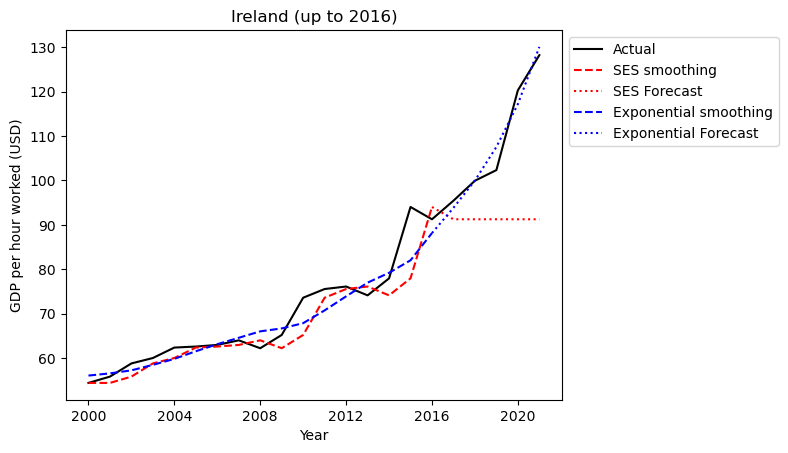

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\scipy\optimize\_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\scipy\optimize\_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


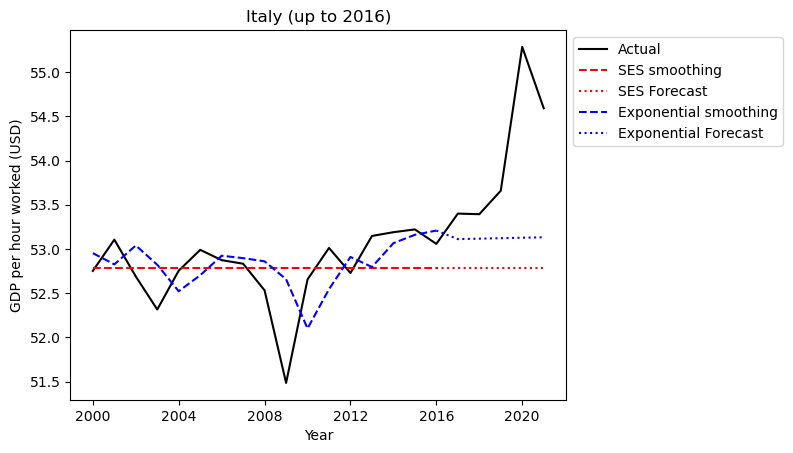

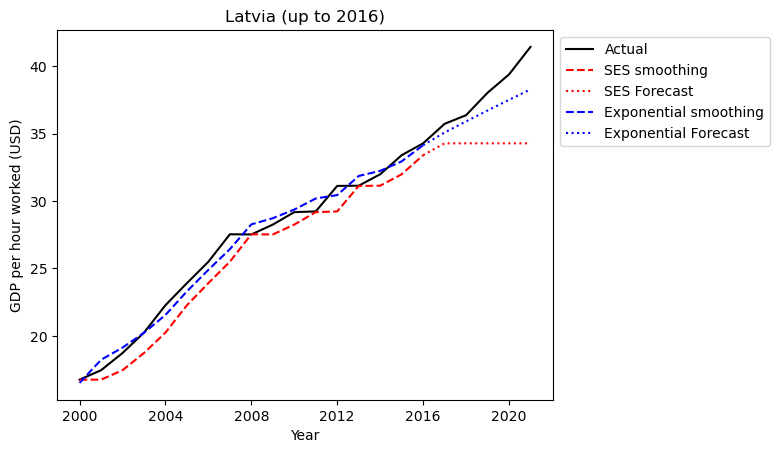

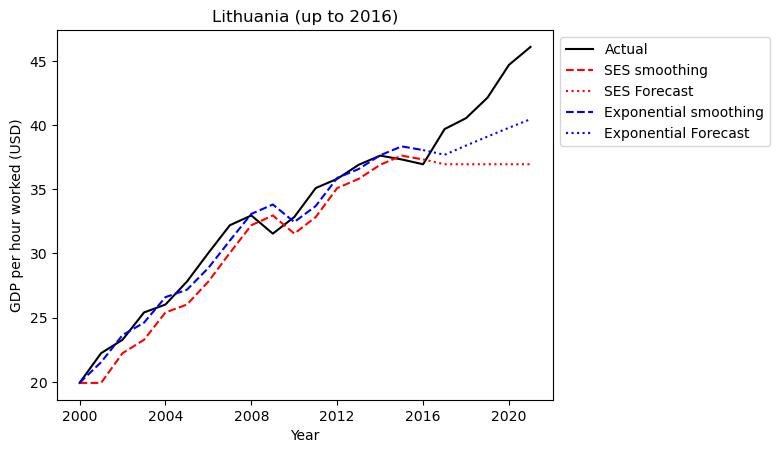

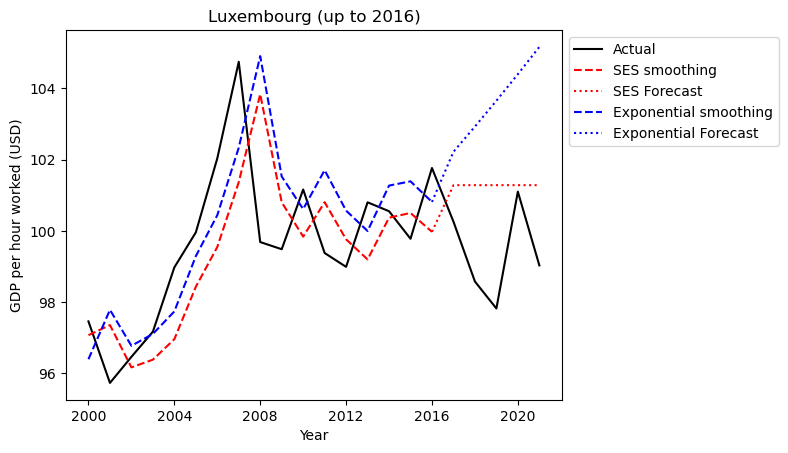

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


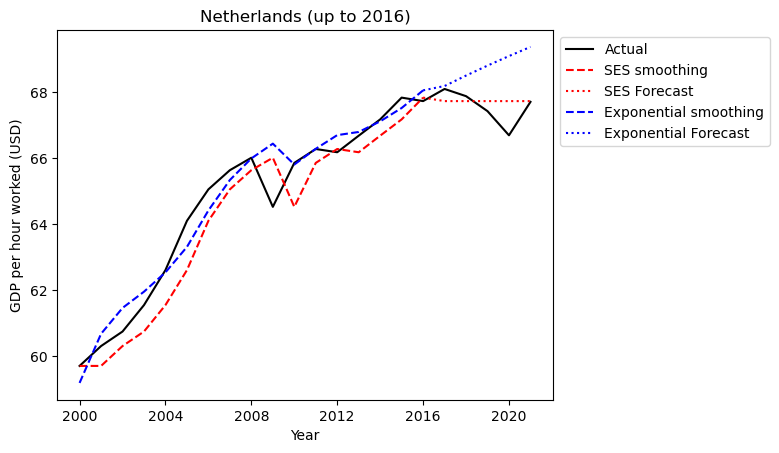

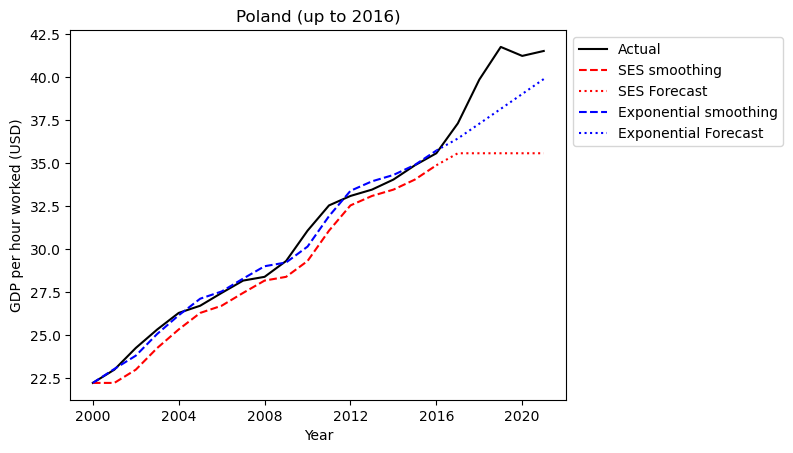

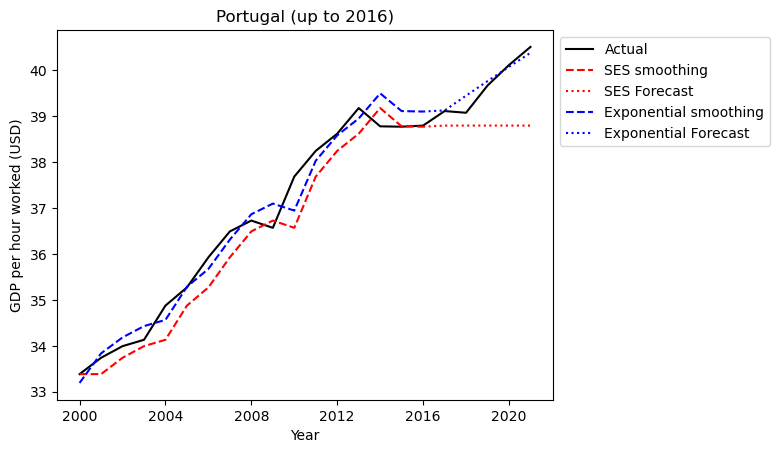

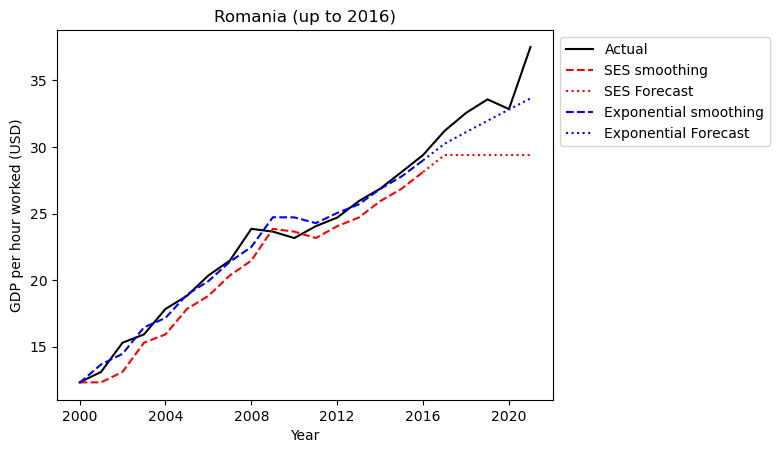

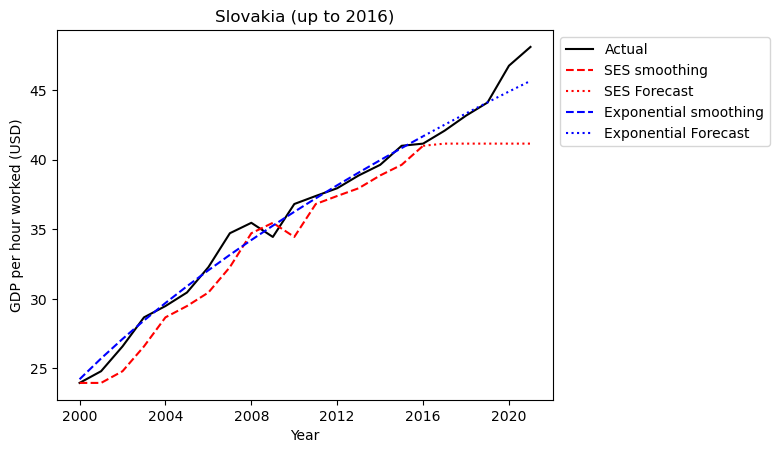

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


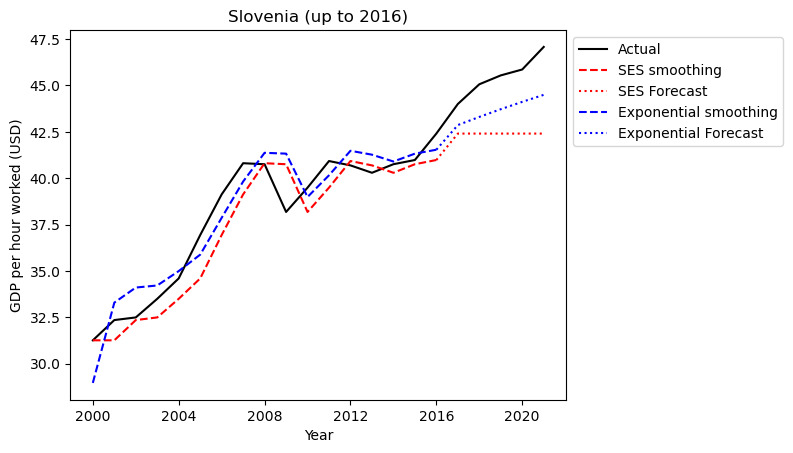

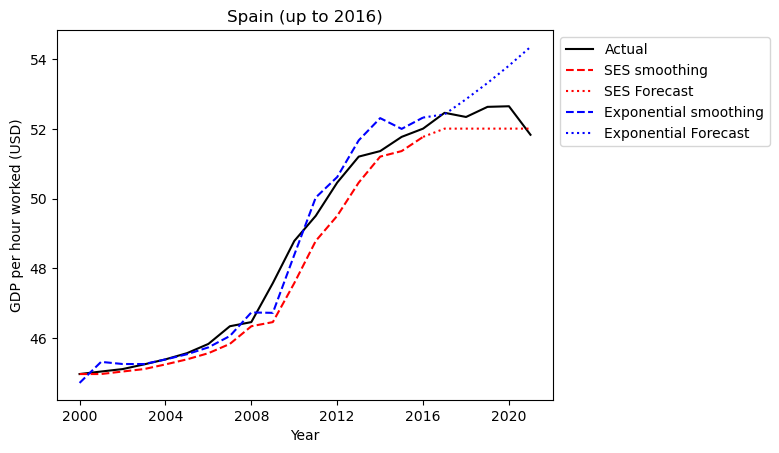

c:\Users\jylin\anaconda3\envs\ads_labs\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


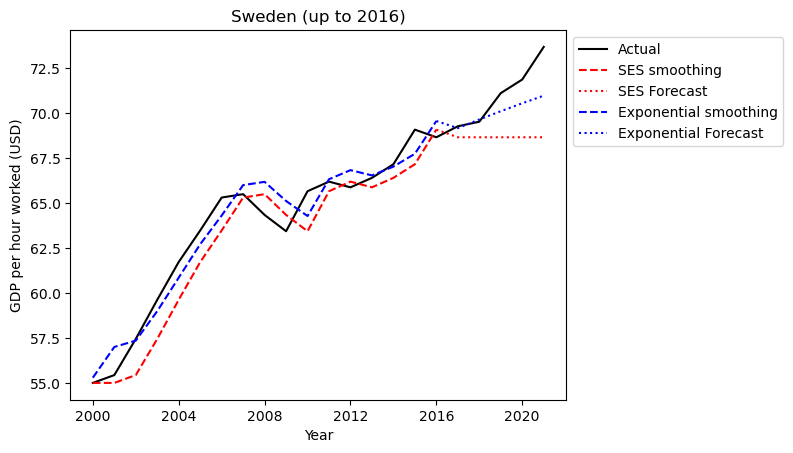

In [8]:
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue

    # Plot the data
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    plot_smoothed_data_past(country+" (up to 2016)", country_series, index, pred_date_start=2016)

The issue with using Exponential Smoothing is that it seems to push the trends forwards in time (see 2009). So while it can do a decent job at predicting the future, it probably is not a good choice for filling in missing data.

Furthermore, it isn't that great at predicting the future, so going to look into ARIMA

## ARIMA

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -18.551
Date:                Sun, 02 Apr 2023   AIC                             43.102
Time:                        23:13:17   BIC                             46.235
Sample:                    01-01-2000   HQIC                            43.782
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.011     93.459      0.000       0.979       1.021
ma.L1         -0.9934      3.085     -0.322      0.747      -7.041       5.054
sigma2         0.2888      0.898      0.322      0.7

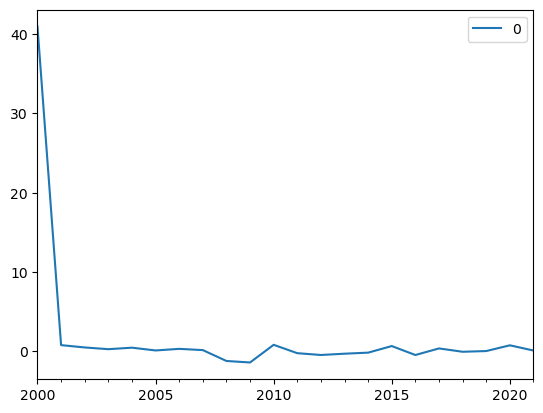

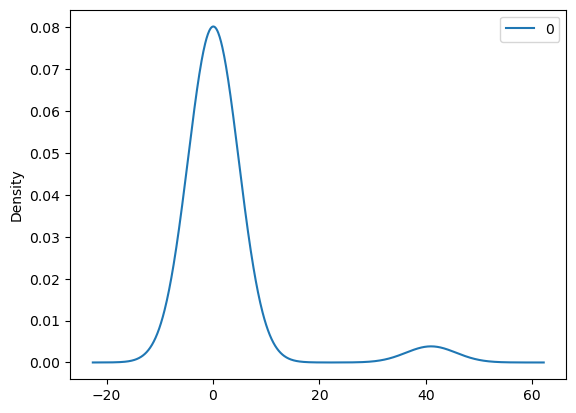

               0
count  22.000000
mean    1.904043
std     8.744169
min    -1.410955
25%    -0.221764
50%     0.127828
75%     0.476637
max    40.966693


In [9]:
# REFERENCE: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
def plot_arima_residual_errors(series, arima_order=(1, 1, 1)):
    # ARIMA
    model = ARIMA(series, order=arima_order)
    model_fit = model.fit()
    print(model_fit.summary())

    # Plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot()
    plt.show()

    # Plot density plot of residual errors
    residuals.plot(kind='kde')
    plt.show()

    print(residuals.describe())
plot_arima_residual_errors(labour_mean_series)

As seen in those graphs, looks like there shouldn't be much residual errors, only at the start, so let's try to predict the future with it

In [10]:
# Evaluate an ARIMA model using a walk-forward validation
def run_arima_model(X, arima_order):
    # Prepare training dataset
    train_size = 17 # train up to and including 2016
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])

    results = {
        "train": train,
        "test": test,
        "predictions": predictions,
        "train_size": train_size,
        "history": history
    }
    return results

def plot_arima_model(title, X, arima_order, test_only=False):
    results = run_arima_model(X, arima_order)
    train_size = results["train_size"]
    test = results["test"]
    predictions = results["predictions"]
    
    # Plot graph
    if not test_only:
        plt.plot(index, X, label='Actual')
        plt.plot(index[train_size:], predictions, label='Predictions', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()
    else:
        years = [str(i) for i in range(2000, 2022)]
        plt.plot(years[train_size:], test, label='Actual')
        plt.plot(years[train_size:], predictions, label='Predictions', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()

def evaluate_arima_model(X, arima_order):
    results = run_arima_model(X, arima_order)
    test = results["test"]
    predictions = results["predictions"]
    
    # Calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

Let's try to tune the parameters to get the best hyperparameters

In [11]:
# Tune the ARIMA model
# REFERENCE: https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    # print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    return best_cfg

p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
best_cfg = evaluate_models(labour_mean_series, p_values, d_values, q_values)

Best ARIMA(2, 2, 2) MSE=0.126


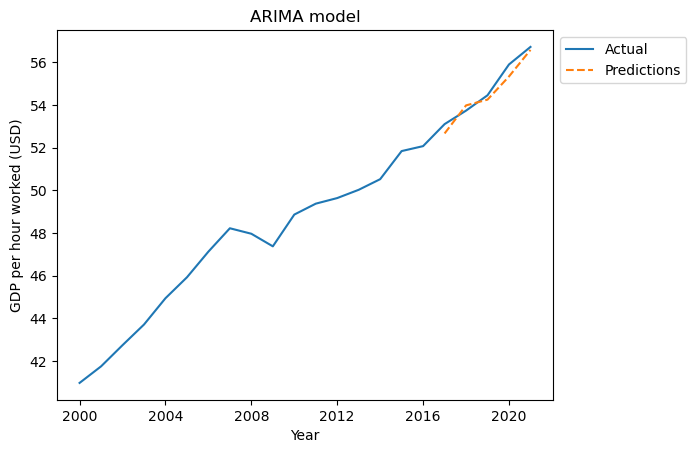

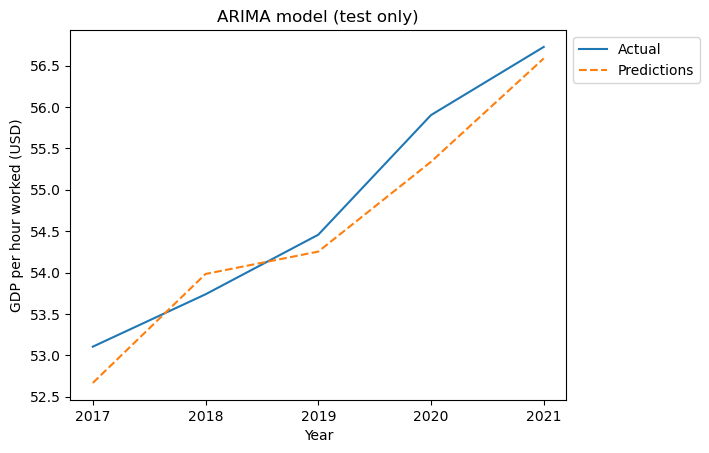

In [12]:
# Plot the best ARIMA model
plot_arima_model("ARIMA model", labour_mean_series, best_cfg)
plot_arima_model("ARIMA model (test only)", labour_mean_series, best_cfg, test_only=True)

And looking back at the residual errors with the best hyperparameters...

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   22
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 -16.141
Date:                Sun, 02 Apr 2023   AIC                             42.282
Time:                        23:13:58   BIC                             47.260
Sample:                    01-01-2000   HQIC                            43.254
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7372      0.340     -2.171      0.030      -1.403      -0.072
ar.L2         -0.0959      0.319     -0.300      0.764      -0.722       0.530
ma.L1          0.0036    171.967   2.08e-05      1.0

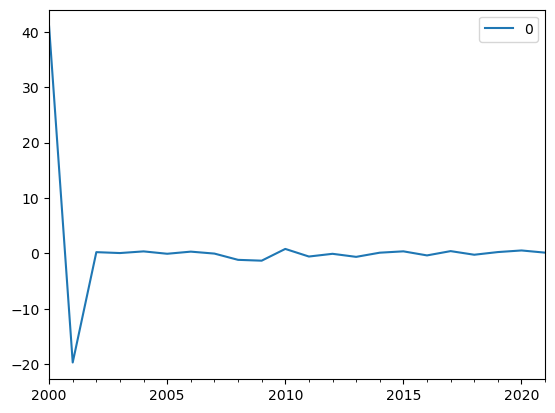

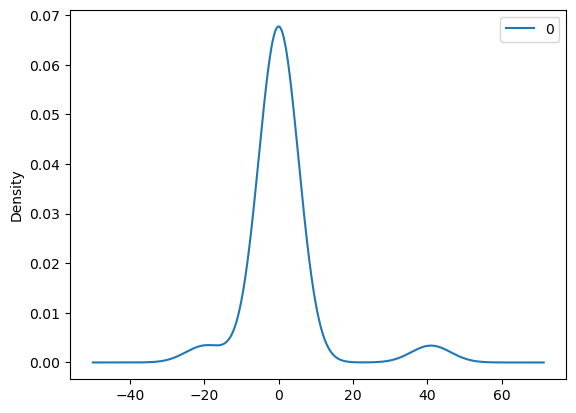

               0
count  22.000000
mean    0.919401
std     9.888985
min   -19.705902
25%    -0.341785
50%     0.086015
75%     0.342877
max    40.966693


In [13]:
# REFERENCE: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
plot_arima_residual_errors(labour_mean_series, arima_order=best_cfg)

Looking pretty good, let's try it on each country

In [15]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

country_arima_orders = {}
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue

    # Find best ARIMA model for each country
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    country_cfg = evaluate_models(country_series, p_values, d_values, q_values)
    country_arima_orders[country] = country_cfg

Best ARIMA(4, 2, 2) MSE=0.371
Best ARIMA(1, 1, 1) MSE=1.207
Best ARIMA(0, 2, 1) MSE=0.107
Best ARIMA(0, 1, 0) MSE=3.045
Best ARIMA(0, 2, 1) MSE=0.257
Best ARIMA(6, 2, 0) MSE=0.188
Best ARIMA(1, 2, 0) MSE=1.208
Best ARIMA(1, 1, 1) MSE=0.450
Best ARIMA(2, 1, 0) MSE=0.625
Best ARIMA(6, 2, 1) MSE=0.052
Best ARIMA(0, 1, 0) MSE=0.687
Best ARIMA(10, 2, 1) MSE=0.956
Best ARIMA(4, 2, 0) MSE=39.347
Best ARIMA(10, 2, 1) MSE=0.156
Best ARIMA(10, 1, 2) MSE=0.103
Best ARIMA(0, 2, 1) MSE=1.567
Best ARIMA(0, 0, 0) MSE=1.528
Best ARIMA(0, 1, 0) MSE=0.391
Best ARIMA(8, 1, 1) MSE=0.787
Best ARIMA(0, 2, 2) MSE=0.049
Best ARIMA(1, 2, 2) MSE=3.218
Best ARIMA(0, 2, 1) MSE=0.523
Best ARIMA(6, 2, 1) MSE=0.112
Best ARIMA(10, 0, 1) MSE=0.131
Best ARIMA(4, 2, 2) MSE=0.405


Draw exponential smoothing vs arima

In [58]:
# Plot Exponential Smoothing vs ARIMA
def plot_exp_smoothing_vs_arima(title, X, arima_order, test_only=False):
    # ARIMA
    results = run_arima_model(X, arima_order)
    train_size = results["train_size"]
    test = results["test"]
    predictions = results["predictions"]

    # Exponential Smoothing
    fit = ExponentialSmoothing(
        X[:train_size],
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(5)
    exp_smoothed = fit.fittedvalues
    exp_forecast = forecast.values
    if not test_only:
        exp_forecast = np.insert(exp_forecast, 0, exp_smoothed[:train_size])
    
    # Plot graph
    if not test_only:
        plt.plot(index, X, label='Actual')
        plt.plot(index, exp_forecast, label='Exponential Smoothing', linestyle='--')
        plt.plot(index[train_size:], predictions, label='ARIMA', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()
    else:
        years = [str(i) for i in range(2000, 2022)]
        plt.plot(years[train_size:], test, label='Actual')
        plt.plot(years[train_size:], exp_forecast, label='Exponential Smoothing', linestyle='--')
        plt.plot(years[train_size:], predictions, label='ARIMA', linestyle='--')
        plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
        plt.xlabel("Year")
        plt.ylabel('GDP per hour worked (USD)')
        plt.title(title)
        plt.show()

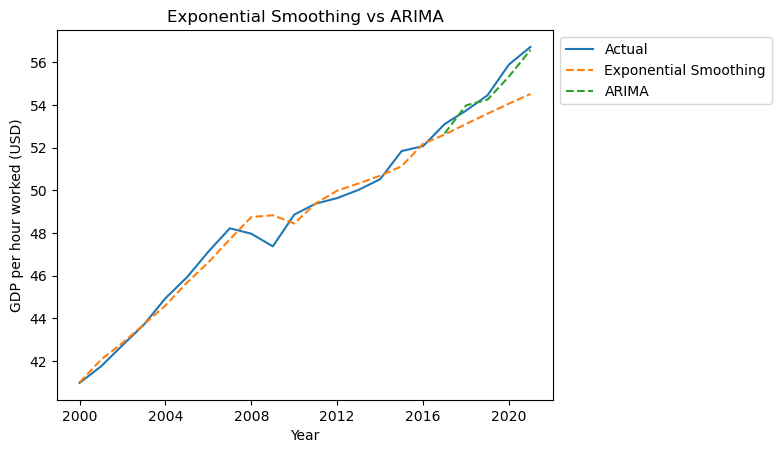

In [59]:
plot_exp_smoothing_vs_arima("Exponential Smoothing vs ARIMA", labour_mean_series, best_cfg)

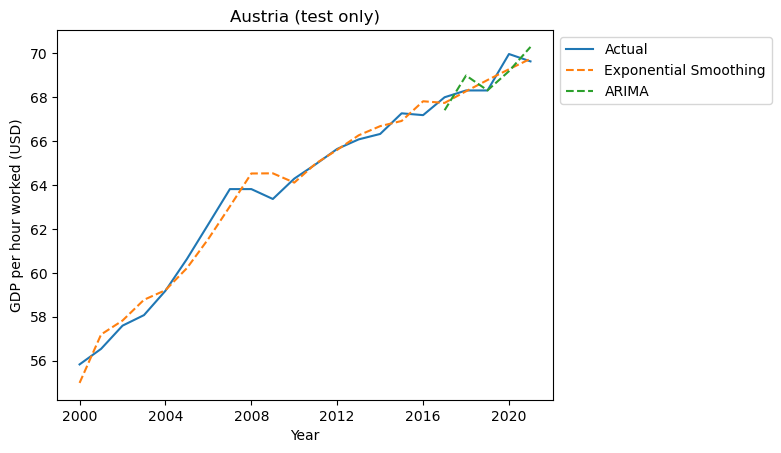

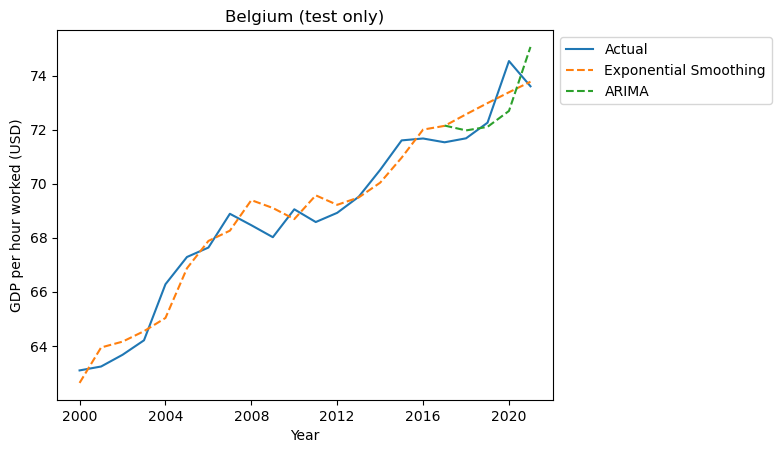

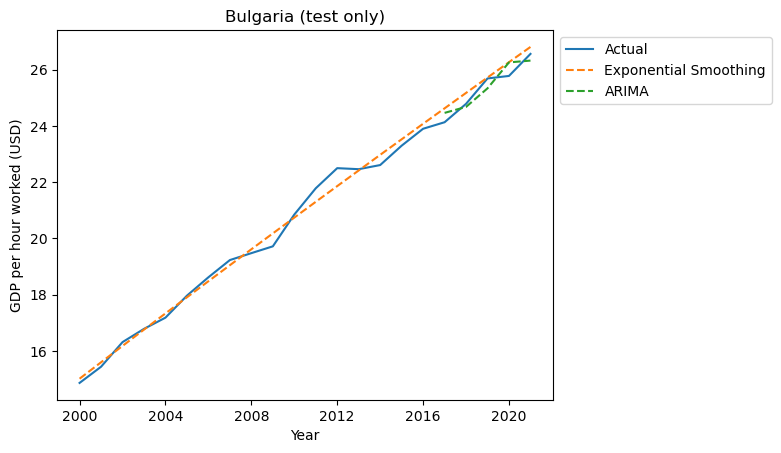

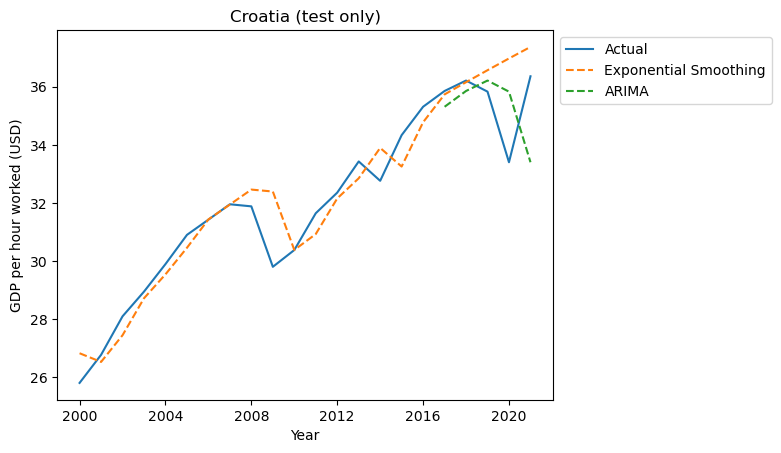

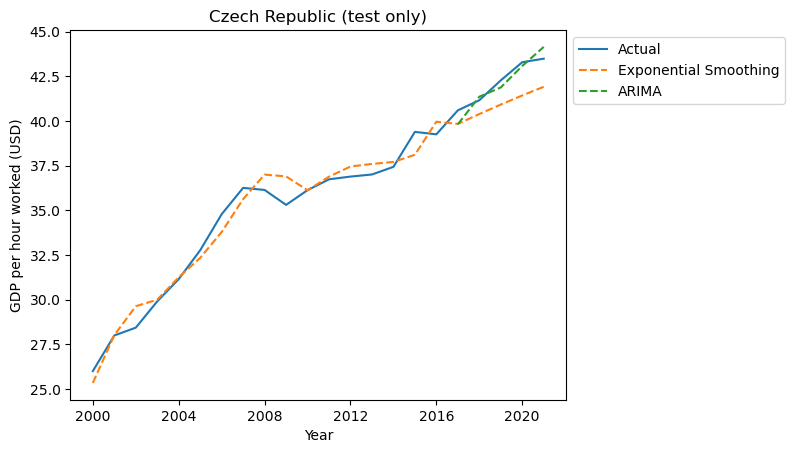

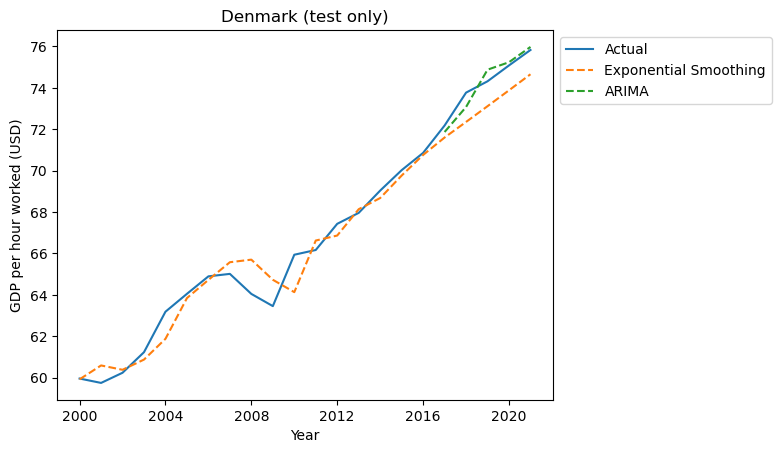

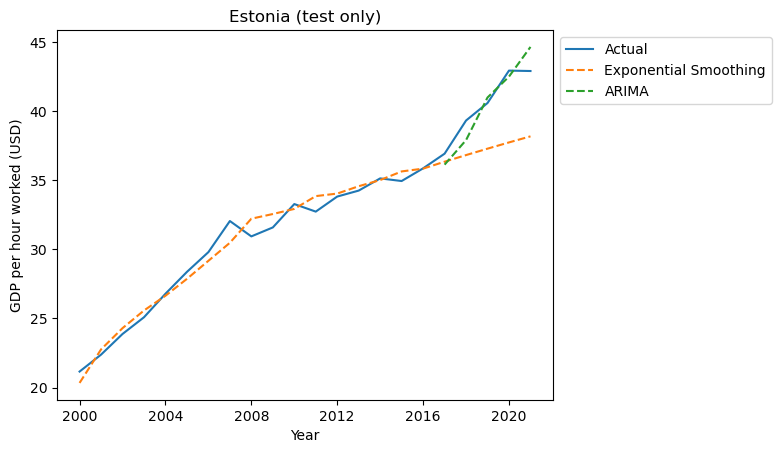

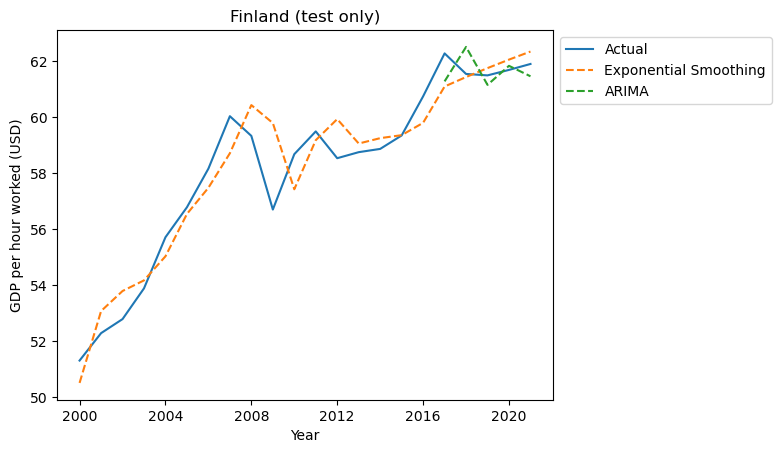

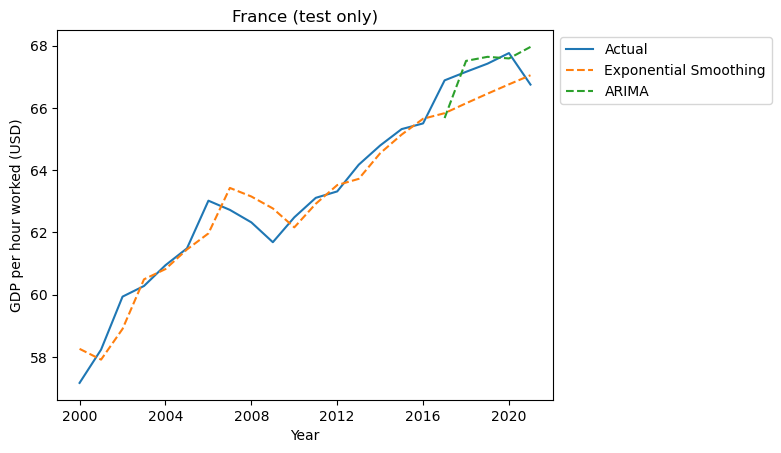

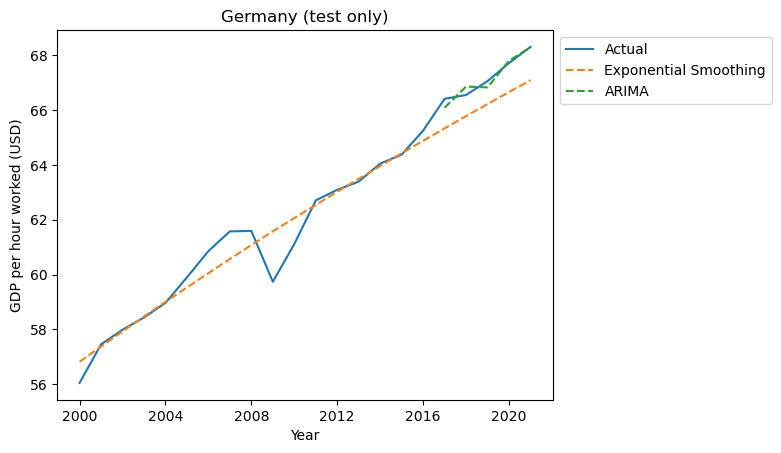

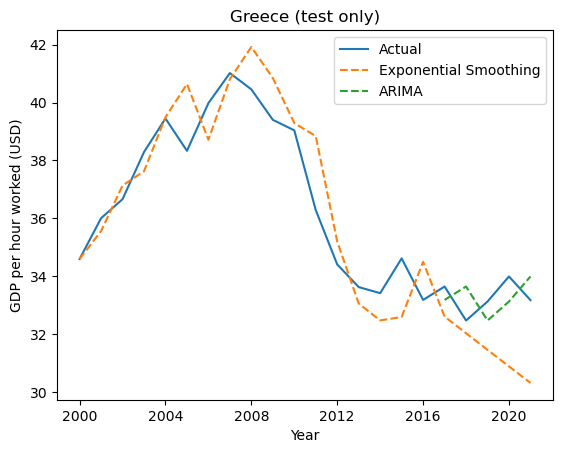

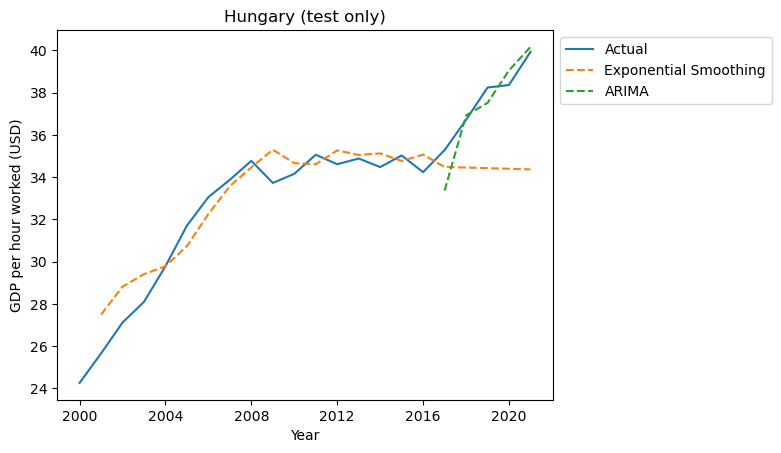

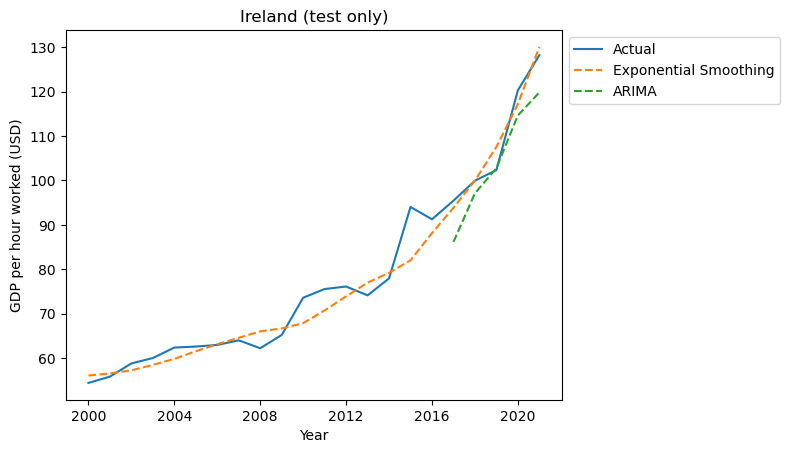

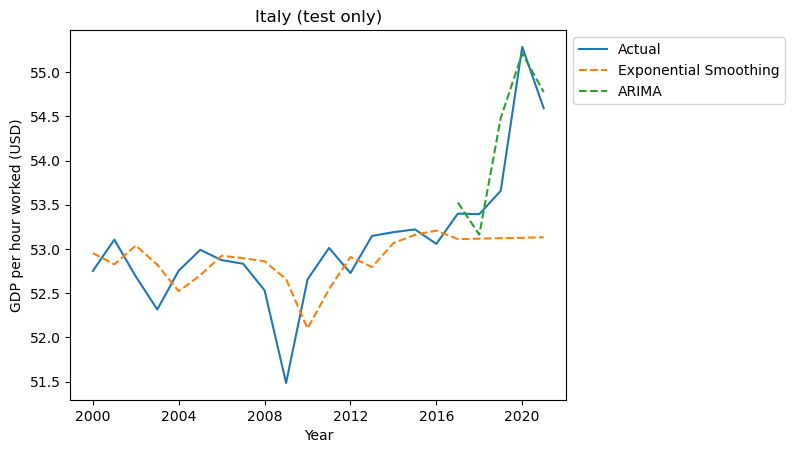

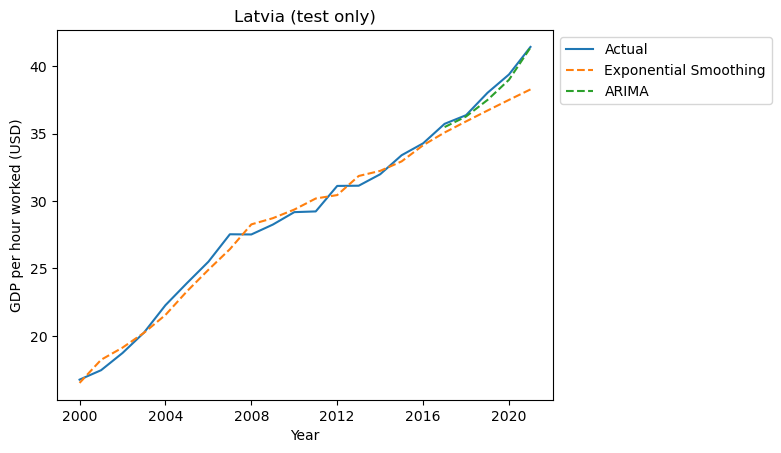

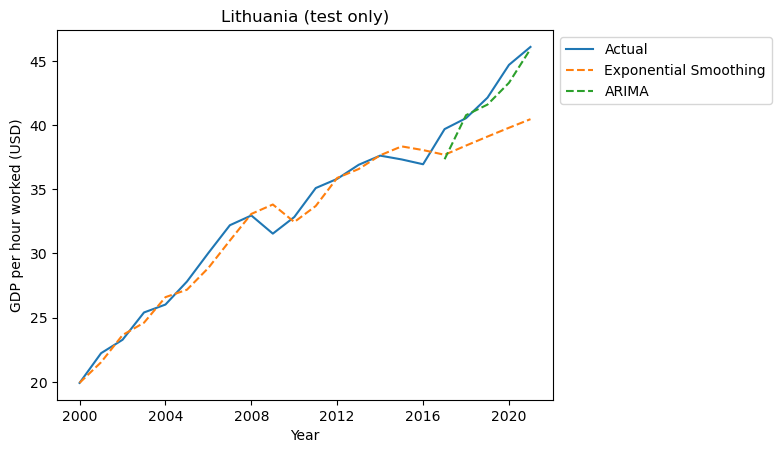

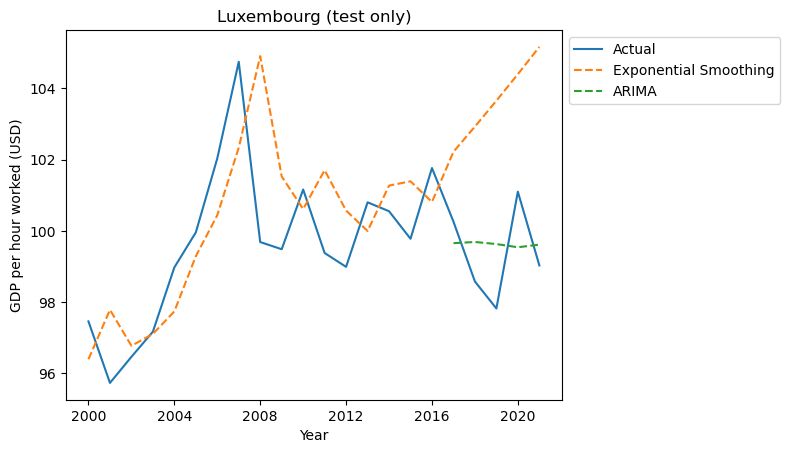

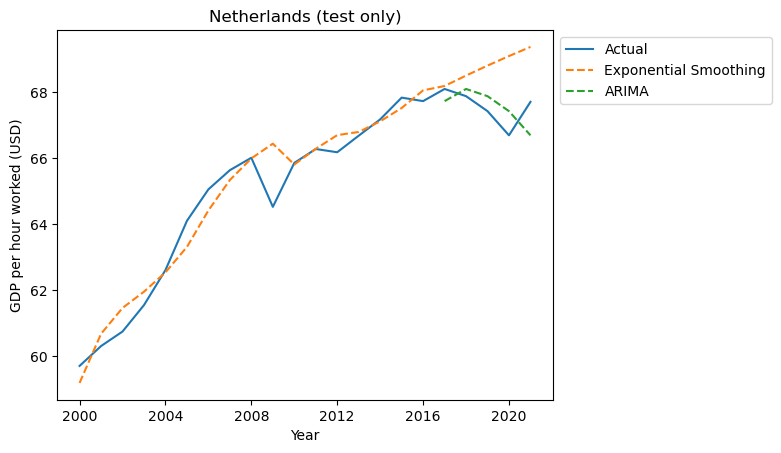

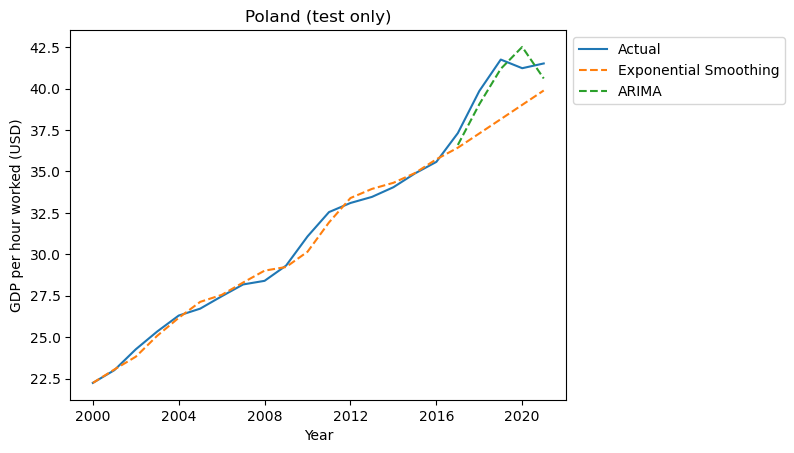

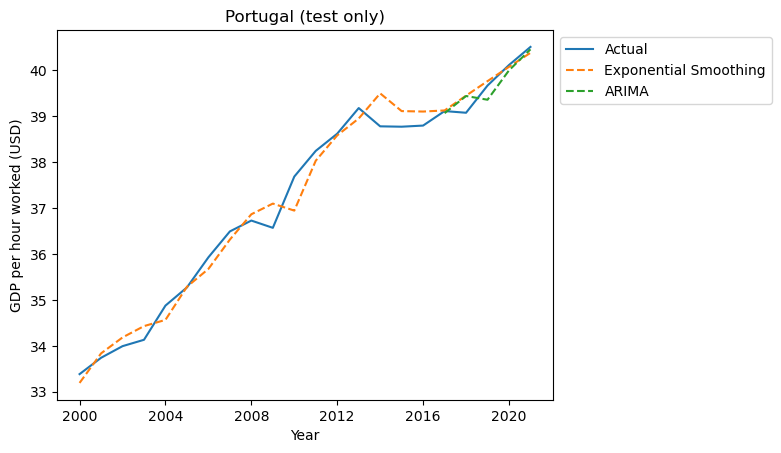

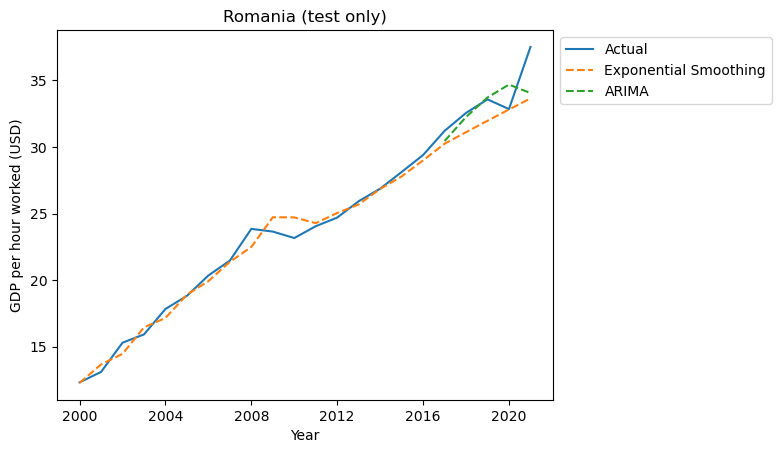

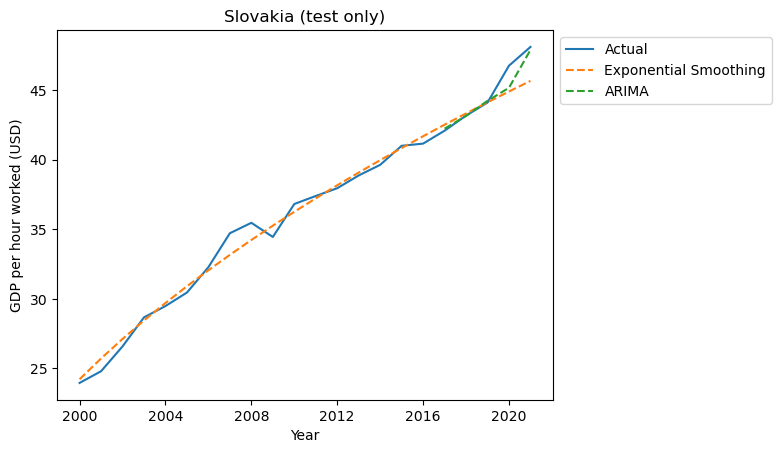

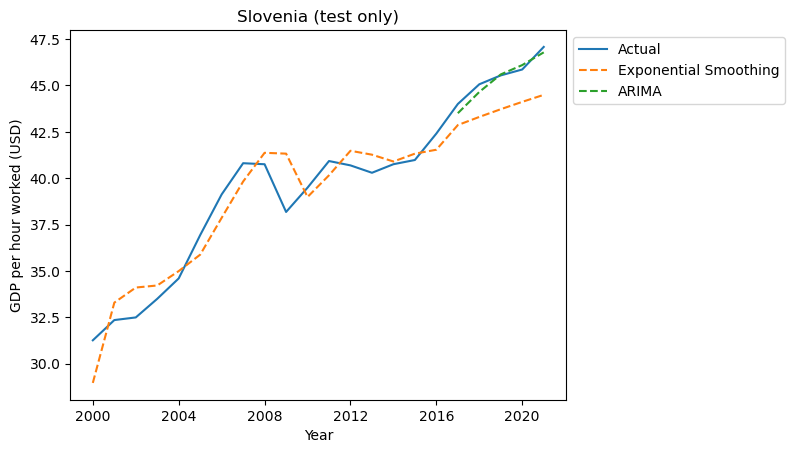

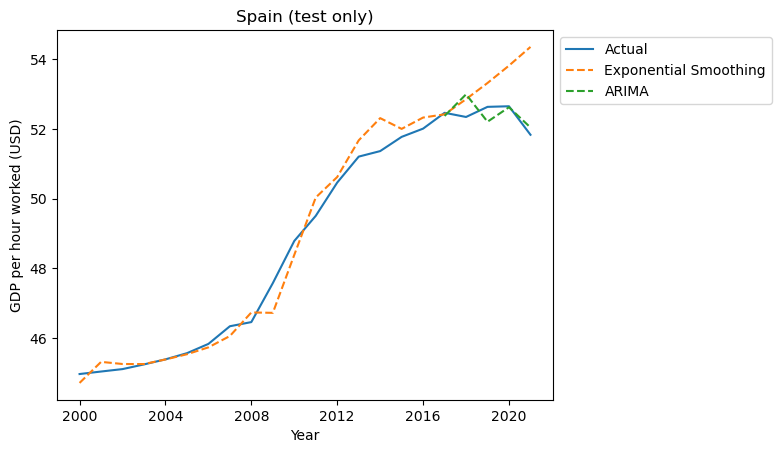

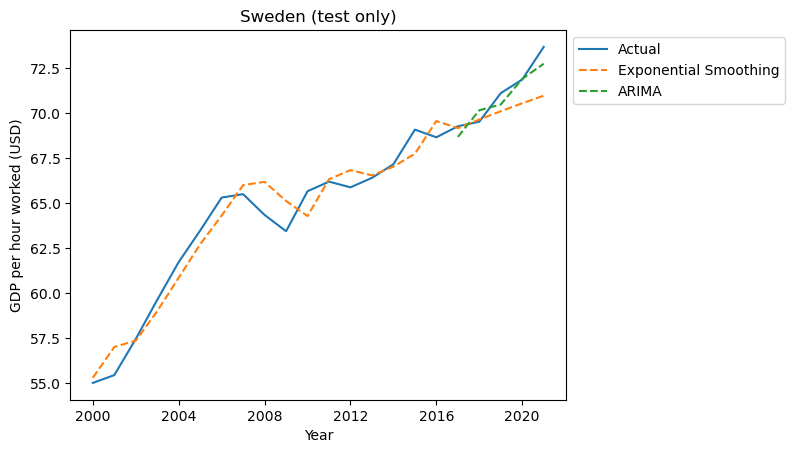

In [60]:
# Plot the data
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue
    
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    country_cfg = country_arima_orders[country]

    plot_exp_smoothing_vs_arima(country+" (test only)", country_series, country_cfg)

Looks a lot more crazy here, but let's actually run it through some correlation coefficients for a numeric comparison between Exponential Smoothing and ARIMA.
Only going to look at correlation coefficients for the test section for ARIMA

In [68]:
# Get correlation coefficient for test and prediction for exponential smoothing and ARIMA
df_results = pd.DataFrame(columns=['Name', 'Exp Smoothing', 'ARIMA'])
df_results.set_index('Name', inplace=True)

def get_correlation_coefficient(actual, pred):
    df = pd.DataFrame({'actual': actual, 'pred': pred})
    return df['actual'].corr(df['pred'])

def get_correlation_for_series(name, series, cfg=best_cfg):
    # Exponential Smoothing
    fit = ExponentialSmoothing(
        series[:17],
        trend="add",
        use_boxcox=True,
        initialization_method="estimated"
    ).fit()
    forecast = fit.forecast(5)
    exp_forecast = forecast.values
    exp_corr = get_correlation_coefficient(series[17:], exp_forecast)

    # ARIMA
    results = run_arima_model(series, cfg)
    predictions = results["predictions"]
    arima_corr = get_correlation_coefficient(series[17:], predictions)

    df_results.loc[name] = [exp_corr, arima_corr]


# Get correlation coefficients for mean labour productivity
get_correlation_for_series("Mean", labour_mean_series)

# Get correlation coefficients for each country
for country in cLib.get_countries():
    # Get country data and make index the year
    country_code = cLib.get_country_data(country).alpha3
    country_data = df_formatted[df_formatted['LOCATION'] == country_code]
    country_data.set_index('YEAR', inplace=True)
    country_data.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(country_data['PRODUCTIVITY'].values) == 0:
        continue

    # Plot the data
    country_series = pd.Series(country_data['PRODUCTIVITY'].values, index=index)
    get_correlation_for_series(country, country_series, cfg=country_arima_orders[country])

df_results

,Exp Smoothing,ARIMA
Name,,
Mean,0.987371,0.978231
Austria,0.873147,0.773468
Belgium,0.850022,0.556169
Bulgaria,0.980769,0.922326
Croatia,-0.238426,-0.376998
Czech Republic,0.983412,0.961558
Denmark,0.980183,0.969277
Estonia,0.971075,0.960095
Finland,-0.329520,-0.407705


In [70]:
# Drop first row and get mean of df_results
df_results.drop(df_results.index[0], inplace=True)
df_results.mean()

Exp Smoothing    0.519618
ARIMA            0.606510
dtype: float64

Both Exponential smoothing and ARIMA performed poorly, but ARIMA performed better overall

# Per subregions

In [46]:
# Get mean productivity for each subregion per year
subregions_dict = cLib.get_subregions_data()
subregions = cLib.get_subregions()
countries =  cLib.get_countries()
df_subregions = pd.DataFrame(columns=['SUBREGION', 'YEAR', 'PRODUCTIVITY'])
subregion_productivity = {}
for subregion in subregions:
    for year in range(2000, 2022):
        df_toadd = pd.DataFrame({'SUBREGION': subregion, 'YEAR': year, 'PRODUCTIVITY': 0}, index=[0])
        df_subregions = pd.concat([df_subregions, df_toadd], ignore_index=True)

# Fill empty dataframe with mean of productivity for each subregion
for subregion in subregions:
    subregion_productivity[subregion] = {}
    for year in range(2000, 2022):
        subregion_productivity[subregion][year] = 0

for subregion in subregions:
    for country in subregions_dict[subregion]:
        country_code = cLib.get_country_data(country).alpha3
        df_country = df_formatted[df_formatted['LOCATION'] == country_code]
        for year in range(2000, 2022):
            df_toadd = df_country[df_country['YEAR'] == year]
            if not df_toadd.empty:
                subregion_productivity[subregion][year] += df_toadd['PRODUCTIVITY'].values[0]

for subregion in subregions:
    for year in range(2000, 2022):
        mean_val = subregion_productivity[subregion][year] / len(subregions_dict[subregion])
        df_subregions.loc[(df_subregions['SUBREGION'] == subregion) & (df_subregions['YEAR'] == year), 'PRODUCTIVITY'] = mean_val

df_subregions.head()

,SUBREGION,YEAR,PRODUCTIVITY
0,Central Europe,2000,34.228938
1,Central Europe,2001,35.40208
2,Central Europe,2002,36.355127
3,Central Europe,2003,37.432391
4,Central Europe,2004,38.496143


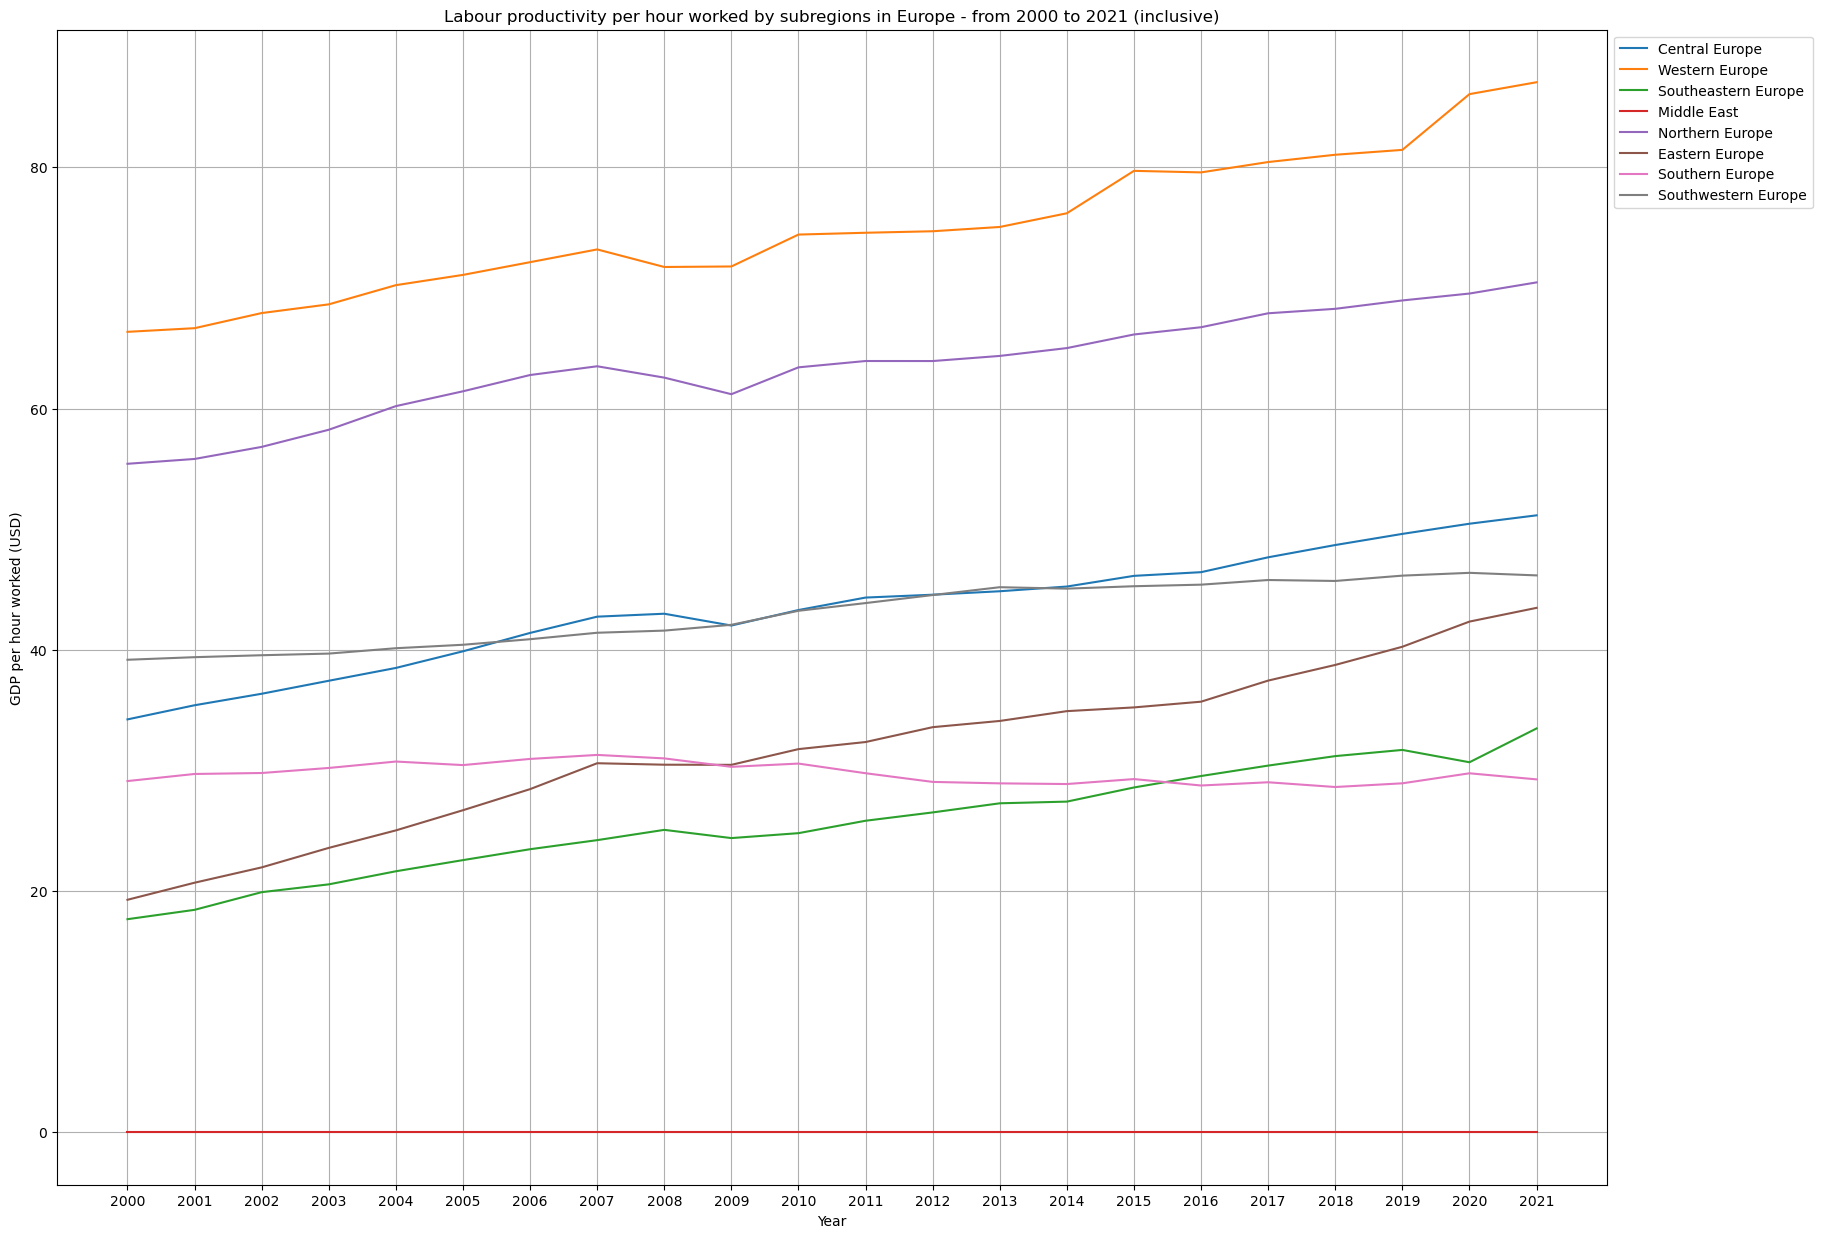

In [47]:
# Plot productivity for each subregion
plt.figure(figsize=(20, 15))
colors = plt.cm.hsv(np.linspace(0, 1, len(subregions)))

for subregion in subregions:
    df_subregion = df_subregions[df_subregions['SUBREGION'] == subregion]
    plt.plot(df_subregion['YEAR'].astype(str), df_subregion['PRODUCTIVITY'], label=subregion)

plt.grid()
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='best')
plt.xlabel("Year")
plt.ylabel('GDP per hour worked (USD)')
plt.title("Labour productivity per hour worked by subregions in Europe - from 2000 to 2021 (inclusive)")
plt.show()

Best ARIMA(6, 2, 2) MSE=0.079


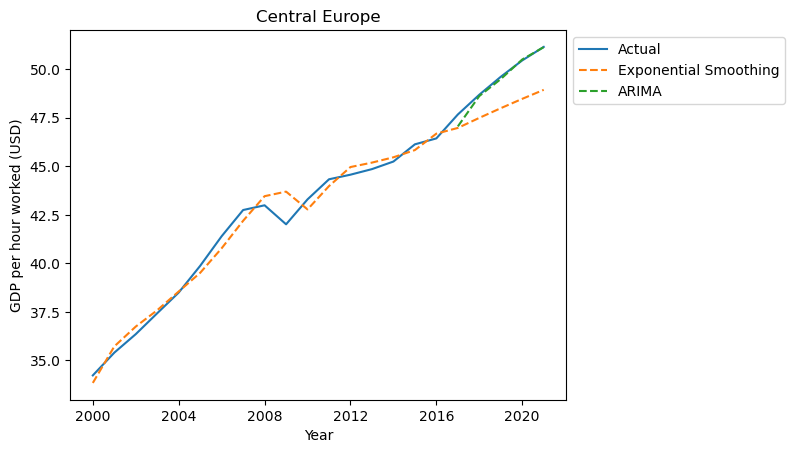

Best ARIMA(4, 2, 0) MSE=1.892


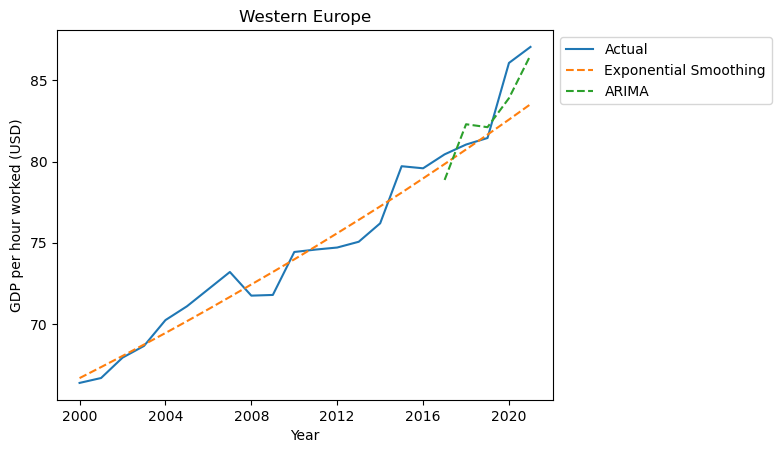

Best ARIMA(10, 2, 0) MSE=0.669


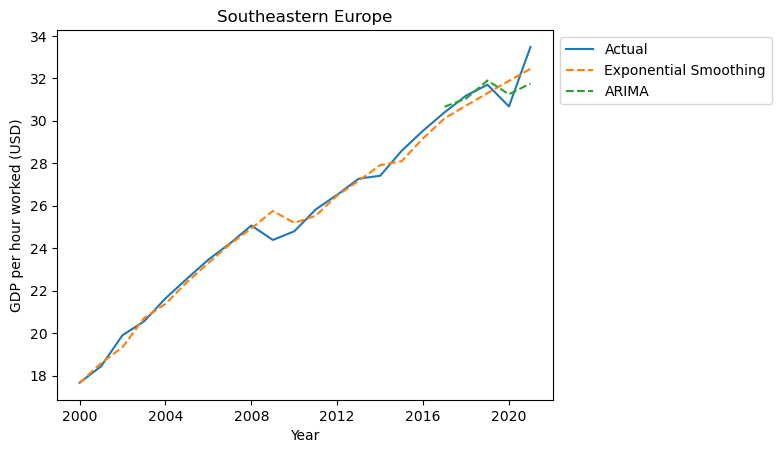

Best ARIMA(0, 2, 1) MSE=0.080


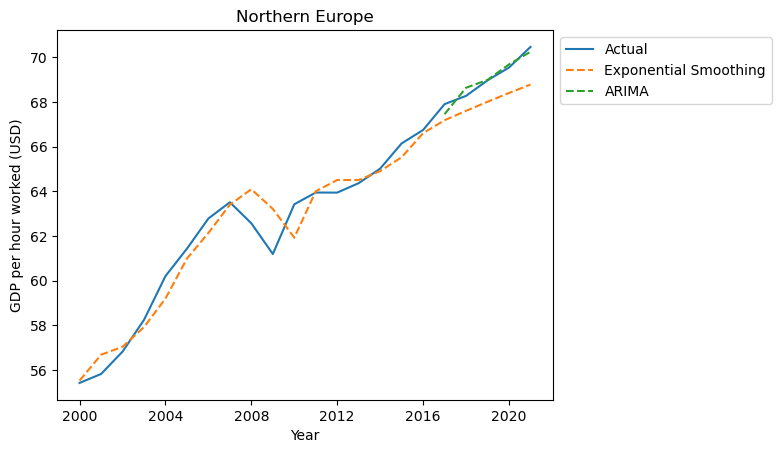

Best ARIMA(6, 2, 2) MSE=0.361


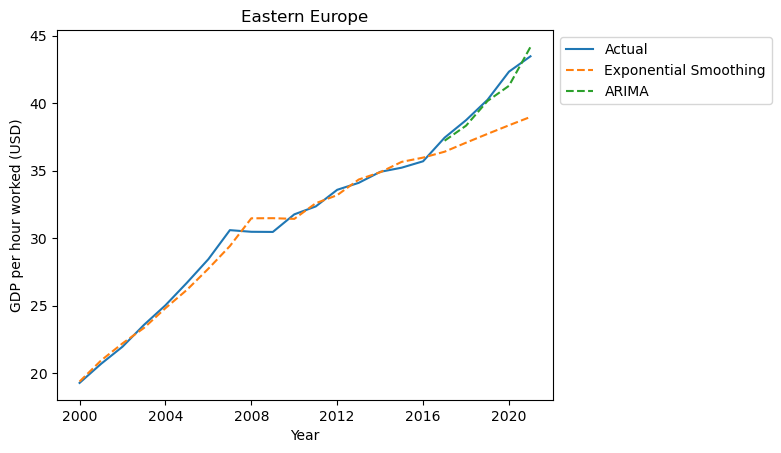

Best ARIMA(4, 0, 2) MSE=0.216


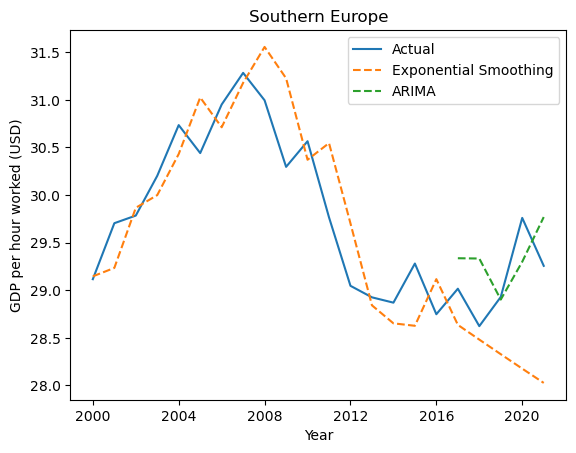

Best ARIMA(0, 1, 0) MSE=0.090


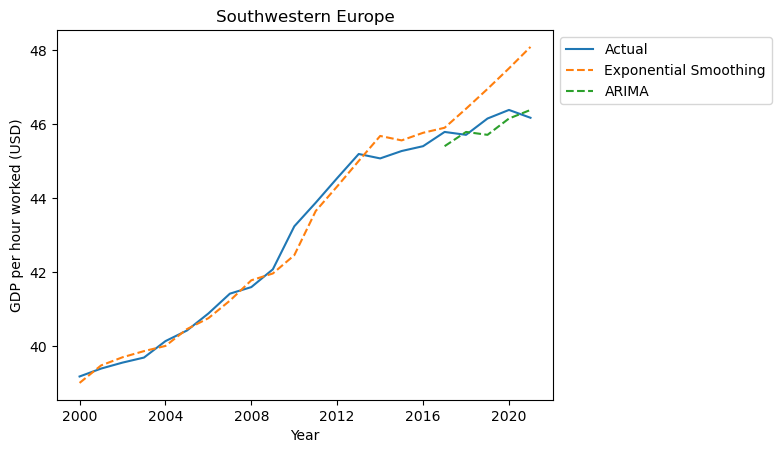

In [66]:
# Predict with both exponential smoothing and ARIMA for each subregion
subregion_arima_orders = {}
for subregion in subregions:
    # Get subregion data and make index the year
    df_subregion = df_subregions[df_subregions['SUBREGION'] == subregion]
    df_subregion.set_index('YEAR', inplace=True)
    df_subregion.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(df_subregion['PRODUCTIVITY'].values) == 0:
        continue

    subregion_series = pd.Series(df_subregion['PRODUCTIVITY'].values, index=index)
    subregion_series = subregion_series.astype('float64')

    # Exponential Smoothing
    try: # Middle East is constant because no data for Cyprus, so ignore it
        fit = ExponentialSmoothing(
            subregion_series,
            trend="add",
            use_boxcox=True,
            initialization_method="estimated"
        ).fit()
    except:
        continue
    forecast = fit.forecast(5)
    exp_forecast = forecast.values

    # ARIMA
    subregion_cfg = evaluate_models(subregion_series, p_values, d_values, q_values)
    subregion_arima_orders[subregion] = subregion_cfg

    # Plot the data
    plot_exp_smoothing_vs_arima(subregion, subregion_series, subregion_cfg)

In [73]:
# Get correlation coefficient for test and prediction for exponential smoothing and ARIMA
df_results = pd.DataFrame(columns=['Name', 'Exp Smoothing', 'ARIMA'])
df_results.set_index('Name', inplace=True)

# Get correlation coefficients for mean labour productivity
get_correlation_for_series("Mean", labour_mean_series)

for subregion in subregions:
    # Get subregion data and make index the year
    df_subregion = df_subregions[df_subregions['SUBREGION'] == subregion]
    df_subregion.set_index('YEAR', inplace=True)
    df_subregion.index.freq = 'AS'
    index = pd.date_range(start='2000', end='2021', freq='AS')

    # Ignore time series with no values
    if len(df_subregion['PRODUCTIVITY'].values) == 0 or subregion not in subregion_arima_orders:
        continue

    subregion_series = pd.Series(df_subregion['PRODUCTIVITY'].values, index=index)
    subregion_series = subregion_series.astype('float64')
    get_correlation_for_series(subregion, subregion_series, subregion_arima_orders[subregion])
df_results

,Exp Smoothing,ARIMA
Name,,
Mean,0.987371,0.978231
Central Europe,0.998784,0.995536
Western Europe,0.933340,0.884830
Southeastern Europe,0.730150,0.744013
Northern Europe,0.987263,0.955172
Eastern Europe,0.995804,0.974383
Southern Europe,-0.601227,0.228357
Southwestern Europe,0.799320,0.668342


In [74]:
# Drop first row and get mean of df_results
df_results.drop(df_results.index[0], inplace=True)
df_results.mean()

Exp Smoothing    0.691919
ARIMA            0.778662
dtype: float64

Interestingly it performed a lot better for the subregions, but still not great. It is worth looking at alternative predictive models